In [41]:
import shutil

shutil.rmtree('./dataset')


## Download all necessary data

For this section we are downloading the dataset we used for training the model

*Note: To download the dataset you need to have the **kaggle.json** api key in your working directory*

In [2]:
# Create the .kaggle directory (if it doesn't exist)
!mkdir -p ~/.kaggle

# Copy the uploaded kaggle.json file to the .kaggle directory
!cp ./kaggle.json ~/.kaggle/

# Set the required file permissions (read/write for user only)
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API token configured.")

# --- Run this cell AFTER configuring kaggle.json above ---

# Download the dataset using the standard slug
!kaggle datasets download -d hasyimabdillah/workoutexercises-images

# Unzip the downloaded file (Kaggle usually names the zip after the dataset slug)
# Use -o to overwrite existing files without prompting, useful for reruns
!unzip -o workoutexercises-images.zip -d dataset

print("Dataset downloaded and unzipped successfully.")

Streaming output truncated to the last 5000 lines.
  inflating: dataset/pull up/pull up_700221.jpg  
  inflating: dataset/pull up/pull up_700231.jpg  
  inflating: dataset/pull up/pull up_700241.jpg  
  inflating: dataset/pull up/pull up_700251.jpg  
  inflating: dataset/pull up/pull up_700261.jpg  
  inflating: dataset/pull up/pull up_800001.jpg  
  inflating: dataset/pull up/pull up_800011.jpg  
  inflating: dataset/pull up/pull up_800021.jpg  
  inflating: dataset/pull up/pull up_800031.jpg  
  inflating: dataset/pull up/pull up_800041.jpg  
  inflating: dataset/pull up/pull up_800051.jpg  
  inflating: dataset/pull up/pull up_800061.jpg  
  inflating: dataset/pull up/pull up_800071.jpg  
  inflating: dataset/pull up/pull up_800081.jpg  
  inflating: dataset/pull up/pull up_800091.jpg  
  inflating: dataset/pull up/pull up_800101.jpg  
  inflating: dataset/pull up/pull up_800111.jpg  
  inflating: dataset/pull up/pull up_800121.jpg  
  inflating: dataset/pull up/pull up_800131.jpg  

## Install required Dependencies

In [16]:
!pip install imutils
!pip install requests
!pip install torch torchvision --upgrade
!pip install opencv-python mediapipe

## Setting up and Preparing Dataset Paths

Here we just define some variables and a function for the paths that will be used later on

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil
from imutils import paths
import cv2
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import mediapipe as mp
import math
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset paths
data_dir = Path("/content/dataset")  # Update to match dataset structure
train_dir = data_dir / "train"
val_dir = data_dir / "val"
test_dir = data_dir / "test"

# Ensure dataset directories exist
def check_directories():
    if not data_dir.exists():
        raise FileNotFoundError(f"Dataset directory {data_dir} not found. Ensure dataset is correctly placed.")

## Functions for preprocessing

### `load_datasets()`
Loads the training, validation, and test datasets using the folder structure and applies appropriate image transformations.

**Returns:**
- `dict`: A dictionary with keys `'train'`, `'val'`, and `'test'`, each mapping to a `torchvision.datasets.ImageFolder` dataset with corresponding transformations.

---

### `prepare_dataset()`
Prepares the dataset by creating a structured folder hierarchy (`train`, `val`, `test`) and populating it with images split from the original dataset directory. Ensures class-balanced stratified splitting and copies images into label-specific folders.

**Actions:**
- Creates `train_dir`, `val_dir`, and `test_dir` directories if they don’t exist.
- Splits the dataset into 70% training, 15% validation, and 15% test sets using stratification based on class labels.
- Copies images into subfolders corresponding to their class labels in each of the split directories.

---

### `get_transforms()`
Defines the data augmentation and preprocessing transformations for the train and validation/test datasets.

**Returns:**
- `dict`: A dictionary with transformation pipelines for:
  - `"train"`: Resize, random horizontal flip, random rotation, color jitter, tensor conversion, normalization.
  - `"val"`: Resize, tensor conversion, normalization.

---

### `get_dataloaders(datasets_dict)`
Creates PyTorch `DataLoader` objects for the training, validation, and test datasets.

**Parameters:**
- `datasets_dict` (`dict`): A dictionary containing `torchvision.datasets.ImageFolder` datasets for keys `"train"`, `"val"`, and `"test"`.

**Returns:**
- `dict`: A dictionary with keys:
  - `"train"`: `DataLoader` with `shuffle=True` for training.
  - `"val"`: `DataLoader` with `shuffle=False` for validation.
  - `"test"`: `DataLoader` with `shuffle=False` for testing.  
Each DataLoader uses a `batch_size` of 16 and `num_workers=4` for parallel loading.

In [5]:
# Load datasets
def load_datasets():
    transforms_dict = get_transforms()
    print(train_dir)
    return {
        "train": datasets.ImageFolder(train_dir, transform=transforms_dict["train"]),
        "val": datasets.ImageFolder(val_dir, transform=transforms_dict["val"]),
        "test": datasets.ImageFolder(test_dir, transform=transforms_dict["val"])
    }

# Prepare dataset
def prepare_dataset():
    if not train_dir.exists():
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        image_paths = list(paths.list_images(data_dir))
        train_paths, rest_paths = train_test_split(image_paths, test_size=0.3, stratify=[Path(p).parent.name for p in image_paths], random_state=42)
        val_paths, test_paths = train_test_split(rest_paths, test_size=0.5, stratify=[Path(p).parent.name for p in rest_paths], random_state=42)
        print(val_paths)
        for path_list, folder in zip([train_paths, val_paths, test_paths], [train_dir, val_dir, test_dir]):
            for img_path in path_list:
                print(img_path)
                label = Path(img_path).parent.name
                label_dir = folder / label
                label_dir.mkdir(parents=True, exist_ok=True)
                shutil.copy(img_path, label_dir / Path(img_path).name)

# Define transformations
def get_transforms():
    return {
        "train": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

# Create DataLoaders
def get_dataloaders(datasets_dict):
    return {
        "train": DataLoader(datasets_dict["train"], batch_size=16, shuffle=True, num_workers=4),
        "val": DataLoader(datasets_dict["val"], batch_size=16, shuffle=False, num_workers=4),
        "test": DataLoader(datasets_dict["test"], batch_size=16, shuffle=False, num_workers=4)
    }

## Running all our preprocessing

In [6]:
check_directories()
prepare_dataset()
datasets_dict = load_datasets()
dataloaders = get_dataloaders(datasets_dict)

Streaming output truncated to the last 5000 lines.
/content/dataset/tricep pushdown/tricep pushdown_4000301.jpg
/content/dataset/t bar row/t bar row_500241.jpg
/content/dataset/plank/plank_700811.jpg
/content/dataset/plank/plank_702451.jpg
/content/dataset/bench press/bench press_800061.jpg
/content/dataset/tricep pushdown/tricep pushdown_4400041.jpg
/content/dataset/decline bench press/dbp_600201.jpg
/content/dataset/squat/squat_500451.jpg
/content/dataset/pull up/pull up_600151.jpg
/content/dataset/deadlift/deadlift_900051.jpg
/content/dataset/decline bench press/dbp_500621.jpg
/content/dataset/deadlift/deadlift_900071.jpg
/content/dataset/incline bench press/incline bench press_g23.jpg
/content/dataset/squat/squat_1700101.jpg
/content/dataset/squat/squat_2600041.jpg
/content/dataset/push up/push up_2500011.jpg
/content/dataset/leg extension/leg extension_2100111.jpg
/content/dataset/decline bench press/dbp_600031.jpg
/content/dataset/shoulder press/shoulder press_g18.jpg
/content/da

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Model and Training

### `get_model()`
Loads a pre-trained ResNet-50 model and customizes the classifier head for a new classification task.

**Returns:**
- `torch.nn.Module`: The modified ResNet-50 model with a new classifier head consisting of:
  - A fully connected layer reducing to 256 features
  - ReLU activation
  - Dropout layer (40%)
  - Final classification layer with `LogSoftmax`
  
The final output size is based on the number of classes found in `train_dir`.

---

### `train_model(model, criterion, optimizer, dataloaders, epochs=10)`
Trains the model using the provided dataloaders, optimizer, and loss function. Tracks and prints training loss, training accuracy, and validation accuracy for each epoch. Saves the model state if validation accuracy improves.

**Parameters:**
- `model` (`torch.nn.Module`): The model to train.
- `criterion` (`torch.nn` loss function): Loss function to optimize.
- `optimizer` (`torch.optim.Optimizer`): Optimizer for training.
- `dataloaders` (`dict`): Dictionary containing `"train"` and `"val"` DataLoaders.
- `epochs` (`int`, optional): Number of training epochs (default is 10).

**Behavior:**
- Trains for the specified number of epochs.
- Evaluates on validation set after each epoch.
- Saves the best-performing model as `best_efficientnet.pth` based on validation accuracy.

---

### Notes:
- All models are assumed to be moved to the appropriate `device` (e.g., GPU or CPU).
- The list of class names is dynamically obtained from the `train_dir`.
- Transformation applied during prediction is consistent with validation preprocessing.


In [7]:
# Load EfficientNet model
def get_model():
    model = models.resnet50(pretrained=True)
    # num_ftrs = model.classifier[1].in_features
    num_ftrs = model.fc.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, len(os.listdir(train_dir))),
        nn.LogSoftmax(dim=1)
    )
    return model.to(device)

# Train model
def train_model(model, criterion, optimizer, dataloaders, epochs=10):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in dataloaders["train"]:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / total

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in dataloaders["val"]:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_efficientnet.pth")

## Classification function

### `classify_image_from_url(image_url, model)`
Downloads an image from a URL, classifies it using the trained model, and displays the result.

**Parameters:**
- `image_url` (`str`): URL of the image to classify.
- `model` (`torch.nn.Module`): Trained model to use for classification.

**Returns:**
- `str`: Predicted label of the image.

**Behavior:**
- Downloads and preprocesses the image.
- Runs inference using the model.
- Displays the image with the predicted label using `matplotlib`.

### `aggregate_classification()`
Classify each frame using the provided model and return an aggregate classification.
    
**Parameters:**
- frames (list): List of image frames (as numpy arrays).
- model: A trained classification model with a predict() method.
- preprocess_func (callable, optional): A function to preprocess each frame.
- If None, frames are passed directly to the model.
- aggregation (str): Aggregation method to combine predictions.
- Options are 'majority' for majority vote or 'average' for averaging probabilities.

**Returns:**
- aggregated_label: The final aggregated classification label.
- frame_labels: A list of classification labels for each frame.


In [8]:
def classify_image_from_url(image_url, model):
    response = requests.get(image_url, stream=True)
    image = Image.open(response.raw).convert("RGB")
    transform = get_transforms()["val"]
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()

    class_names = sorted(os.listdir(train_dir))
    predicted_label = class_names[predicted_class]

    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label

def aggregate_classification(frames, model, preprocess_func=None, aggregation='majority'):
    frame_labels = []
    probabilities_list = []

    for frame in frames:
        # Preprocess the frame if a preprocessing function is provided.
        frame_processed = preprocess_func(frame) if preprocess_func else frame

        # Many models expect a batch dimension so add one if needed.
        frame_processed = np.expand_dims(frame_processed, axis=0)

        # Predict probabilities for the frame.
        pred_probs = model.predict(frame_processed)

        # Save probabilities for averaging if using that method.
        probabilities_list.append(pred_probs[0])

        # Convert the probability vector to a label (assumes np.argmax works correctly).
        label = np.argmax(pred_probs, axis=1)[0]
        frame_labels.append(label)

    # Aggregate predictions based on the chosen method.
    if aggregation == 'majority':
        # Use a majority vote to determine the final label.
        aggregated_label = Counter(frame_labels).most_common(1)[0][0]
    elif aggregation == 'average':
        # Average the probability vectors and choose the label with the highest average probability.
        avg_probs = np.mean(np.array(probabilities_list), axis=0)
        aggregated_label = np.argmax(avg_probs)
    else:
        raise ValueError("Invalid aggregation method. Choose 'majority' or 'average'.")

    return aggregated_label, frame_labels


## Train Model

In [9]:
model = get_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
train_model(model, criterion, optimizer, dataloaders, epochs=5)
# model.load_state_dict(torch.load("best_efficientnet.pth", map_location=device))
# model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


Epoch 1/5 | Train Loss: 0.8514 | Train Acc: 76.91% | Val Acc: 88.55%
Epoch 2/5 | Train Loss: 0.3334 | Train Acc: 90.30% | Val Acc: 89.46%
Epoch 3/5 | Train Loss: 0.2445 | Train Acc: 92.77% | Val Acc: 92.93%
Epoch 4/5 | Train Loss: 0.1952 | Train Acc: 94.41% | Val Acc: 93.36%
Epoch 5/5 | Train Loss: 0.1755 | Train Acc: 94.75% | Val Acc: 91.48%


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


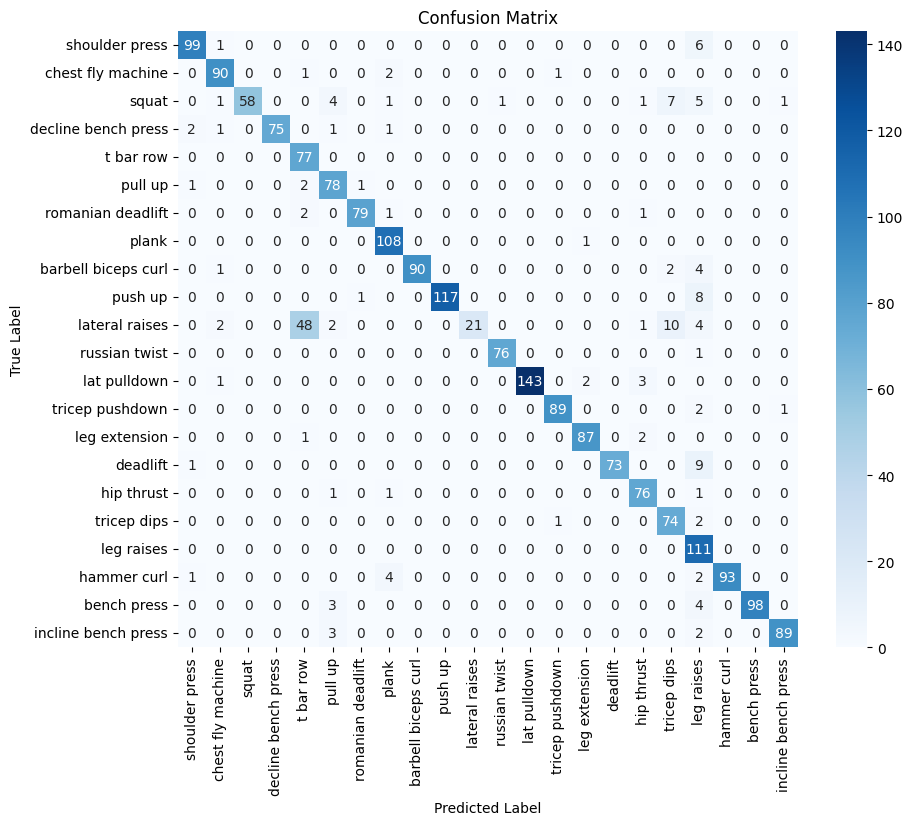

In [13]:
evaluate_model(model, dataloaders['val'])

## Ideal Angles for Comparison
This was a combination of online research and using kaggle datasets to compile this list.

In [26]:
ideal_angles_all_exercises = {
    "plank": {
        "Left Elbow": 180,   # Arms extended
        "Right Elbow": 180,
        "Left Shoulder": 30, # Slight angle from torso
        "Right Shoulder": 30,
        "Left Hip": 180,     # Body in a straight line
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "barbell biceps curl": {
        # Assuming the “top” of the curl with elbows flexed
        "Left Elbow": 60,    # Deep flexion
        "Right Elbow": 60,
        "Left Shoulder": 20, # Slight forward tilt
        "Right Shoulder": 20,
        "Left Hip": 180,     # Standing tall
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "deadlift": {
        # Assuming the top lockout position
        "Left Elbow": 180,
        "Right Elbow": 180,
        "Left Shoulder": 10, # Shoulders slightly behind hips
        "Right Shoulder": 10,
        "Left Hip": 180,     # Fully extended
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "hip thrust": {
        # Top position with hips fully extended
        "Left Elbow": 180,   # Arms often on the bench or stabilizing
        "Right Elbow": 180,
        "Left Shoulder": 90, # Upper back on the bench
        "Right Shoulder": 90,
        "Left Hip": 180,     # Fully extended hips
        "Right Hip": 180,
        "Left Knee": 90,     # Knees bent at top
        "Right Knee": 90
    },
    "lateral raises": {
        # Arms raised to shoulder height
        "Left Elbow": 150,   # Slight bend in the elbow
        "Right Elbow": 150,
        "Left Shoulder": 90, # Arms abducted to shoulder level
        "Right Shoulder": 90,
        "Left Hip": 180,
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "incline bench press": {
        # Top position, arms extended above chest (inclined)
        "Left Elbow": 180,
        "Right Elbow": 180,
        "Left Shoulder": 45, # Arms angled relative to torso (incline)
        "Right Shoulder": 45,
        "Left Hip": 180,
        "Right Hip": 180,
        "Left Knee": 90,     # Often bent on the bench
        "Right Knee": 90
    },
    "squat": {
        # Bottom position (parallel squat)
        "Left Elbow": 0,
        "Right Elbow": 0,
        "Left Shoulder": 0,
        "Right Shoulder": 0,
        "Left Hip": 90,      # Thighs parallel to floor
        "Right Hip": 90,
        "Left Knee": 90,
        "Right Knee": 90
    },
    "t bar row": {
        # Top of the pull
        "Left Elbow": 90,
        "Right Elbow": 90,
        "Left Shoulder": 60, # Arms pulled back
        "Right Shoulder": 60,
        "Left Hip": 120,     # Torso hinged
        "Right Hip": 120,
        "Left Knee": 150,    # Slight bend
        "Right Knee": 150
    },
    "push up": {
        # Bottom position
        "Left Elbow": 90,
        "Right Elbow": 90,
        "Left Shoulder": 90,
        "Right Shoulder": 90,
        "Left Hip": 180,     # Body in straight line
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "leg extension": {
        # Top position with knees extended
        "Left Elbow": 0,     # Arms not heavily involved
        "Right Elbow": 0,
        "Left Shoulder": 0,
        "Right Shoulder": 0,
        "Left Hip": 90,      # Seated
        "Right Hip": 90,
        "Left Knee": 180,    # Extended knee
        "Right Knee": 180
    },
    "lat pulldown": {
        # Bottom position (bar near chest)
        "Left Elbow": 90,
        "Right Elbow": 90,
        "Left Shoulder": 90,
        "Right Shoulder": 90,
        "Left Hip": 90,      # Seated upright
        "Right Hip": 90,
        "Left Knee": 90,
        "Right Knee": 90
    },
    "tricep pushdown": {
        # Arms fully extended at bottom
        "Left Elbow": 20,
        "Right Elbow": 20,
        "Left Shoulder": 0,
        "Right Shoulder": 0,
        "Left Hip": 180,
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "pull up": {
        # Top position (chin over bar)
        "Left Elbow": 60,
        "Right Elbow": 60,
        "Left Shoulder": 60,
        "Right Shoulder": 60,
        "Left Hip": 180,
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "romanian deadlift": {
        # Bottom position (slight knee bend, hips hinged)
        "Left Elbow": 180,
        "Right Elbow": 180,
        "Left Shoulder": 10,
        "Right Shoulder": 10,
        "Left Hip": 120,
        "Right Hip": 120,
        "Left Knee": 120,
        "Right Knee": 120
    },
    "leg press": {
        # Bottom position with knees bent
        "Left Elbow": 0,     # Arms not involved
        "Right Elbow": 0,
        "Left Shoulder": 0,
        "Right Shoulder": 0,
        "Left Hip": 90,
        "Right Hip": 90,
        "Left Knee": 90,
        "Right Knee": 90
    },
    "romanian single leg": {
        # Similar hinge to romanian deadlift but single-leg
        "Left Elbow": 180,
        "Right Elbow": 180,
        "Left Shoulder": 10,
        "Right Shoulder": 10,
        "Left Hip": 120,
        "Right Hip": 120,
        "Left Knee": 120,
        "Right Knee": 120
    },
    "chest fly machine": {
        # Arms nearly extended in front
        "Left Elbow": 150,
        "Right Elbow": 150,
        "Left Shoulder": 30, # Shoulders slightly flexed
        "Right Shoulder": 30,
        "Left Hip": 90,
        "Right Hip": 90,
        "Left Knee": 90,
        "Right Knee": 90
    },
    "bench press": {
        # Top position, arms fully extended
        "Left Elbow": 180,
        "Right Elbow": 180,
        "Left Shoulder": 0,
        "Right Shoulder": 0,
        "Left Hip": 90,
        "Right Hip": 90,
        "Left Knee": 90,
        "Right Knee": 90
    },
    "russian twist": {
        # Mid-twist, leaning back
        "Left Elbow": 90,
        "Right Elbow": 90,
        "Left Shoulder": 30, # Rotated trunk
        "Right Shoulder": 30,
        "Left Hip": 90,
        "Right Hip": 90,
        "Left Knee": 90,
        "Right Knee": 90
    },
    "hammer curl": {
        # Top position, neutral grip
        "Left Elbow": 60,
        "Right Elbow": 60,
        "Left Shoulder": 20,
        "Right Shoulder": 20,
        "Left Hip": 180,
        "Right Hip": 180,
        "Left Knee": 180,
        "Right Knee": 180
    },
    "tricep dips": {
        # Bottom position, elbows bent
        "Left Elbow": 90,
        "Right Elbow": 90,
        "Left Shoulder": 90,
        "Right Shoulder": 90,
        "Left Hip": 180,
        "Right Hip": 180,
        "Left Knee": 90,
        "Right Knee": 90
    },
}


Processed 30 frames.
Processed 60 frames.
Processed 90 frames.

Aggregated Classification: barbell biceps curl
Frame-level Labels: ['barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps curl', 'barbell biceps c

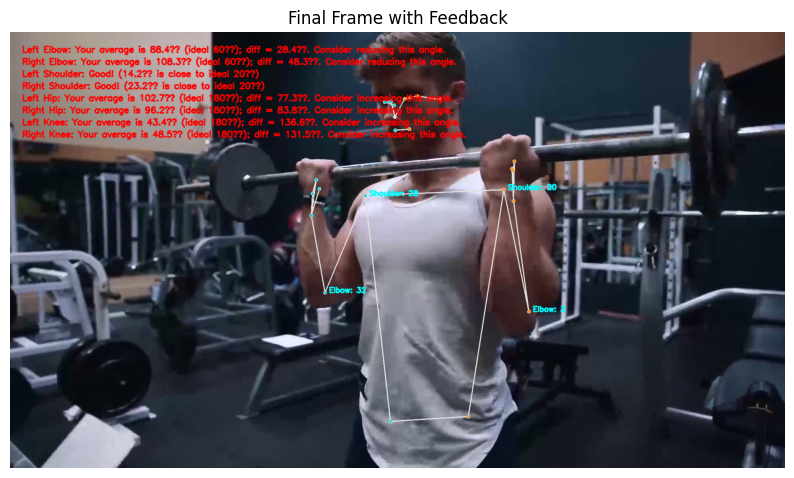

In [34]:
import cv2
import mediapipe as mp
import numpy as np
import math
import os
import torch
from collections import Counter
from matplotlib import pyplot as plt
from torchvision import transforms
from PIL import Image

# ---------------------------
# Pose Estimation Setup
# ---------------------------
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

pose_detector = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    smooth_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.7
)

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# ---------------------------
# Define Angles to Calculate
# ---------------------------
ANGLES_TO_CALCULATE = {
    "Left Elbow": (mp_pose.PoseLandmark.LEFT_SHOULDER,
                   mp_pose.PoseLandmark.LEFT_ELBOW,
                   mp_pose.PoseLandmark.LEFT_WRIST),
    "Right Elbow": (mp_pose.PoseLandmark.RIGHT_SHOULDER,
                    mp_pose.PoseLandmark.RIGHT_ELBOW,
                    mp_pose.PoseLandmark.RIGHT_WRIST),
    "Left Shoulder": (mp_pose.PoseLandmark.LEFT_ELBOW,
                      mp_pose.PoseLandmark.LEFT_SHOULDER,
                      mp_pose.PoseLandmark.LEFT_HIP),
    "Right Shoulder": (mp_pose.PoseLandmark.RIGHT_ELBOW,
                       mp_pose.PoseLandmark.RIGHT_SHOULDER,
                       mp_pose.PoseLandmark.RIGHT_HIP),
    "Left Hip": (mp_pose.PoseLandmark.LEFT_SHOULDER,
                 mp_pose.PoseLandmark.LEFT_HIP,
                 mp_pose.PoseLandmark.LEFT_KNEE),
    "Right Hip": (mp_pose.PoseLandmark.RIGHT_SHOULDER,
                  mp_pose.PoseLandmark.RIGHT_HIP,
                  mp_pose.PoseLandmark.RIGHT_KNEE),
    "Left Knee": (mp_pose.PoseLandmark.LEFT_HIP,
                  mp_pose.PoseLandmark.LEFT_KNEE,
                  mp_pose.PoseLandmark.LEFT_ANKLE),
    "Right Knee": (mp_pose.PoseLandmark.RIGHT_HIP,
                   mp_pose.PoseLandmark.RIGHT_KNEE,
                   mp_pose.PoseLandmark.RIGHT_ANKLE),
}

def extract_pose_and_angles(image, pose_detector, visibility_threshold=0.6):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb.flags.writeable = False
    results = pose_detector.process(image_rgb)
    image_rgb.flags.writeable = True
    annotated_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    calculated_angles = {}
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        h, w, _ = annotated_image.shape
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        for angle_name, landmark_indices in ANGLES_TO_CALCULATE.items():
            lm1_idx, vertex_idx, lm2_idx = landmark_indices
            lm1 = landmarks[lm1_idx.value]
            vertex = landmarks[vertex_idx.value]
            lm2 = landmarks[lm2_idx.value]
            if (lm1.visibility > visibility_threshold and
                vertex.visibility > visibility_threshold and
                lm2.visibility > visibility_threshold):
                pt1 = [lm1.x * w, lm1.y * h]
                pt_vertex = [vertex.x * w, vertex.y * h]
                pt2 = [lm2.x * w, lm2.y * h]
                angle_degrees = calculate_angle(pt1, pt_vertex, pt2)
                calculated_angles[angle_name] = angle_degrees
                cv2.putText(annotated_image, f"{angle_name.split(' ')[-1]}: {int(angle_degrees)}",
                            (int(pt_vertex[0]) + 10, int(pt_vertex[1])),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2, cv2.LINE_AA)
    else:
        cv2.putText(annotated_image, "No Pose Detected", (30, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    return annotated_image, calculated_angles

# ---------------------------
# Updated Aggregate Classification Function for PyTorch
# ---------------------------
def aggregate_classification(frames, model, preprocess_func, device, aggregation='majority'):
    frame_labels = []
    probabilities_list = []
    model.eval()
    for frame in frames:
        processed_tensor = preprocess_func(frame).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(processed_tensor)
            probs = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()
        frame_labels.append(predicted_class)
        probabilities_list.append(probs.cpu().numpy()[0])
    if aggregation == 'majority':
        aggregated_index = Counter(frame_labels).most_common(1)[0][0]
    elif aggregation == 'average':
        avg_probs = np.mean(np.array(probabilities_list), axis=0)
        aggregated_index = int(np.argmax(avg_probs))
    else:
        raise ValueError("Invalid aggregation method. Choose 'majority' or 'average'.")
    return aggregated_index, frame_labels

# ---------------------------
# Enhanced Feedback Function
# ---------------------------
def generate_feedback(avg_angles, ideal_angles, tolerance=10):
    feedback_messages = []
    for angle_name in ideal_angles:
        if angle_name in avg_angles:
            diff = avg_angles[angle_name] - ideal_angles[angle_name]
            if abs(diff) > tolerance:
                suggestion = (f"{angle_name}: Your average is {avg_angles[angle_name]:.1f}° "
                              f"(ideal {ideal_angles[angle_name]}°); diff = {abs(diff):.1f}°. ")
                if diff > 0:
                    suggestion += "Consider reducing this angle."
                else:
                    suggestion += "Consider increasing this angle."
                feedback_messages.append(suggestion)
            else:
                feedback_messages.append(f"{angle_name}: Good! ({avg_angles[angle_name]:.1f}° is close to ideal {ideal_angles[angle_name]}°)")
        else:
            feedback_messages.append(f"{angle_name}: Data not available.")
    return feedback_messages

# ---------------------------
# Integrated Video Processing Function with Feedback Overlaid on Final Frame
# ---------------------------
def process_video_with_classification_and_feedback(video_path, pose_detector, classification_model,
                                                   preprocess_func, ideal_angles_all_exercises,
                                                   class_names, device,
                                                   max_frames=None, output_video_path=None):
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frames_for_classification = []
    all_frame_angles = []
    last_annotated_frame = None
    frame_count = 0

    out = None
    if output_video_path:
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        frames_for_classification.append(frame.copy())
        annotated_frame, calculated_angles = extract_pose_and_angles(frame, pose_detector)
        last_annotated_frame = annotated_frame.copy()  # Keep the last annotated frame for final display.
        all_frame_angles.append(calculated_angles)
        if out:
            out.write(annotated_frame)
        if frame_count % 30 == 0:
            print(f"Processed {frame_count} frames.")
        if max_frames is not None and frame_count >= max_frames:
            break

    cap.release()
    if out:
        out.release()

    # Aggregate classification over frames.
    aggregated_index, frame_labels = aggregate_classification(frames_for_classification,
                                                              classification_model,
                                                              preprocess_func,
                                                              device,
                                                              aggregation='majority')
    aggregated_exercise = class_names[aggregated_index]
    print("\nAggregated Classification:", aggregated_exercise)
    print("Frame-level Labels:", [class_names[i] for i in frame_labels])

    # Pull the ideal angles for the classified exercise.
    if aggregated_exercise in ideal_angles_all_exercises:
        ideal_angles = ideal_angles_all_exercises[aggregated_exercise]
    else:
        ideal_angles = {}
        print(f"No ideal angles available for exercise: {aggregated_exercise}")

    # Compute average angles over all processed frames.
    avg_angles = {}
    count = 0
    for angle_dict in all_frame_angles:
        if angle_dict:
            for key, val in angle_dict.items():
                avg_angles[key] = avg_angles.get(key, 0) + val
            count += 1
    if count > 0:
        avg_angles = {key: avg_angles[key] / count for key in avg_angles}
    else:
        print("No angles were calculated from the video.")

    print("\nAverage Angles from Video:")
    for angle, value in avg_angles.items():
        print(f"  {angle}: {value:.2f}°")

    # Generate detailed feedback.
    feedback_messages = generate_feedback(avg_angles, ideal_angles, tolerance=10)
    print("\nFeedback on Workout Form:")
    for msg in feedback_messages:
        print(" -", msg)

    # Overlay feedback messages on the last annotated frame.
    if last_annotated_frame is not None:
        feedback_frame = last_annotated_frame.copy()
        y0, dy = 50, 30
        for i, msg in enumerate(feedback_messages):
            y = y0 + i * dy
            cv2.putText(feedback_frame, msg, (30, y), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (0, 0, 255), 2, cv2.LINE_AA)

        # Display the final annotated frame with feedback.
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(feedback_frame, cv2.COLOR_BGR2RGB))
        plt.title("Final Frame with Feedback")
        plt.axis("off")
        plt.show()

# ---------------------------
# Example Usage
# ---------------------------
# Assume your trained PyTorch classification model is loaded as classification_model.
# Here, we set class_names from ideal_angles_all_exercises keys.
class_names = sorted(list(ideal_angles_all_exercises.keys()))

def preprocess_frame(frame):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform_pipeline(image)

video_file = '/content/barbell biceps curl_0.mp4'  # Update with your video file path.
output_file = '/content/output_workout_analyzed.mp4'  # Optional output file.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

process_video_with_classification_and_feedback(video_file, pose_detector,
                                               model, preprocess_frame,
                                               ideal_angles_all_exercises, class_names,
                                               device, max_frames=150,
                                               output_video_path=output_file)
